# Part 1: Filtering and processing data
The first step of the analysis is to filter the dataframe 'movie.metadata', and to reshape it so that it the relevant features are easily accessible.
#### **1) Importing the data**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import ast
from datetime import datetime


In [19]:
dataframe = pd.read_csv('Data/movie.metadata.tsv', sep='\t', names = ['Wikipedia movieID', 'Freebase movieID', 'Movie name', 'Movie release date', 'Movie box office revenue','Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres' ])

display(dataframe)

,Wikipedia movieID,Freebase movieID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


#### **2) Processing the release date column**

In order to perform a study on month of release, we need to check what is the proportion of movies which don't have the month of release. If this proportion is not too high, we can continue our analysis. We then need to process the release date column so that the month and year of release are easily accessible.


Note: At each transformation of the original dataframe, deep copies are performed in order to keep track of its evolution.

**2.1) Create the "Movie release year" column:**

In [52]:
# Deep copy
# df_with_year := add a release year column
df_with_years = dataframe.copy(deep = True)

# Drop nan values
df_with_years = df_with_years.dropna(subset=['Movie release date'])

# Add release year column
df_with_years['Movie release year'] = df_with_years['Movie release date'].str[0:4]

# Convert to numeric values
df_with_years['Movie release year'] = pd.to_numeric(df_with_years['Movie release year'], errors='raise') 

# Sort the movies by ascending order of release year
df_with_years = df_with_years.sort_values('Movie release year', ascending=True) 

# Drop the first row which has an error in the release year (1010)
df_with_years = df_with_years.drop(df_with_years[df_with_years['Movie release year'] == 1010].index)

# Reset the indexation 
df_with_years = df_with_years.reset_index(drop = True)

df_with_years

,Wikipedia movieID,Freebase movieID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year
0,1082508,/m/044ggd,Roundhay Garden Scene,1888,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1888
1,12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",1889,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1889
2,6431996,/m/0g53t3,"Monkeyshines, No. 1",1890,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}",1890
3,22770416,/m/0gj9h_4,London's Trafalgar Square,1890,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1890
4,27773121,/m/0cc8h1v,Newark Athlete,1891,NaN,0.20,{},{},"{""/m/02hmvc"": ""Short Film""}",1891
...,...,...,...,...,...,...,...,...,...,...
74833,25813358,/m/0gmbk1g,Avatar 2,2015,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...",2015
74834,24179103,/m/0jwx0kc,"I, Robot 2",2015,NaN,NaN,{},{},"{""/m/06n90"": ""Science Fiction""}",2015
74835,3139382,/m/08tyfg,Battle Angel,2016,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2016
74836,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,NaN,{},{},{},2016


**2.2) Percentage missing month per year:** 

Now that the year of release is accessible, the percentage of missing month per year can be computed, so that we can understand better its evolution.

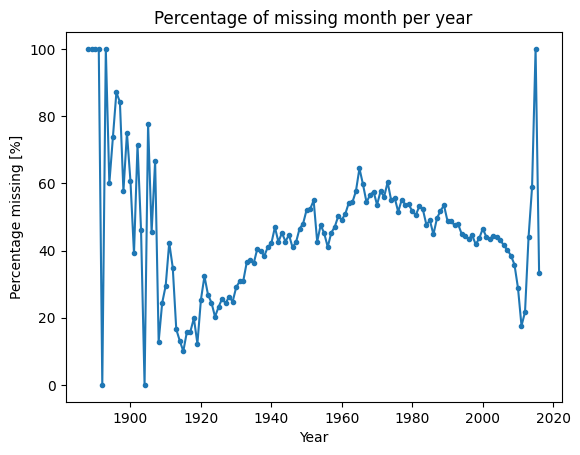

In [55]:
percentage = lambda x: (x.astype(str).apply(len) < 5).mean() * 100

missing_data_percentage = df_with_years.groupby('Movie release year')['Movie release date'].apply(percentage)

plt.plot(missing_data_percentage.index, missing_data_percentage.values, marker='.')
plt.title('Percentage of missing month per year')
plt.xlabel('Year')
plt.ylabel('Percentage missing [%]')
plt.show()

A COMMENTER

**2.3) Proportion of data with a release month:**

In [56]:
# Deep copy
# df_with_months := rows which all have release month 
df_with_months = df_with_years.copy(deep=True)

# Remove the row which don't have the month of release
df_with_months = df_with_months[df_with_months['Movie release date'].str.len() > 4]

# Reset the indexation 
df_with_months = df_with_months.reset_index(drop = True)

display(df_with_months)

# Compute the ratio of usable data
ratio = len(df_with_months)*100/len(dataframe)
print(f"The number of movie with the release month is : {len(df_with_months)}\nThe ratio of films with the release month is : {ratio:.2f}%")

,Wikipedia movieID,Freebase movieID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year
0,9996498,/m/02pz844,Le Clown et ses chiens,1892-10-28,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/0f8l9c"": ""France""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1892
1,9999926,/m/02pzdsc,Un bon bock,1892-10-28,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/0f8l9c"": ""France""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1892
2,6431647,/m/0g53g2,Pauvre Pierrot,1892-10-28,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/0f8l9c"": ""France""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1892
3,10109752,/m/02q23xk,Miss Jerry,1894-10-09,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1894
4,10094757,/m/02q1md8,Chinese Opium Den,1894-10-01,NaN,1.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1894
...,...,...,...,...,...,...,...,...,...,...
42661,35042288,/m/0j630fh,Bulbul,2014-07,NaN,NaN,"{""/m/09bnf"": ""Kannada Language""}","{""/m/03rk0"": ""India""}",{},2014
42662,36534974,/m/0kdy118,Noah,2014-03-28,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01hmnh"": ""Fantasy""}",2014
42663,35764246,/m/0jt01_6,Appayya,2014-08-15,NaN,NaN,"{""/m/09bnf"": ""Kannada Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}",2014
42664,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,NaN,{},{},{},2016


The number of movie with the release month is : 42666
The ratio of films with the release month is : 52.20%


The data which has a release month represent 52% of the entire dataframe, and 42 667 movies, which is an acceptable number for our study. We can then go further in the analysis.

**2.4) Comparison between the original data and the data with the release month available:** yearly evolution of the number of movies

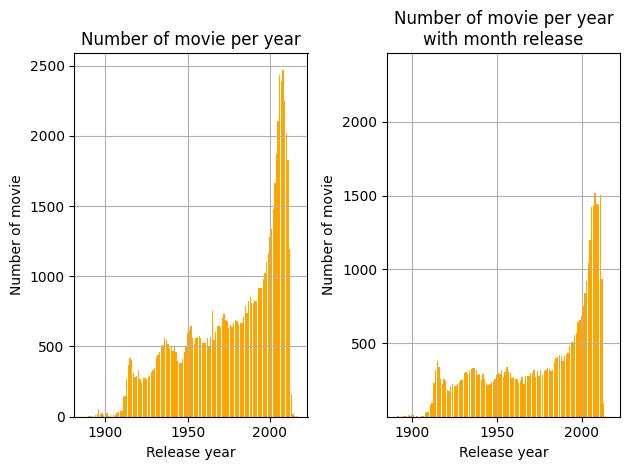

In [58]:
# Counting number of movie per year
film_counts_year = df_with_years['Movie release year'].value_counts().sort_index()

# Counting number of movie with month release per year
film_counts_year_without_missing_months = df_with_months['Movie release year'].value_counts().sort_index()

# Plot the number of movies per year
plt.subplot(1, 2, 1)

plt.bar(film_counts_year.index, film_counts_year.values, color='orange')
plt.title('Number of movie per year')
plt.xlabel('Release year')
plt.ylabel('Number of movie')
plt.grid()

# Plot the number of movies per year
plt.subplot(1, 2, 2)

plt.bar(film_counts_year_without_missing_months.index, film_counts_year_without_missing_months.values, color='orange')
plt.title('Number of movie per year\nwith month release')
plt.xlabel('Release year')
plt.ylabel('Number of movie')
plt.grid()


# Set the same Y-axis limits for both subplots
plt.ylim(min(min(film_counts_year.values), min(film_counts_year_without_missing_months.values)),
        max(max(film_counts_year.values), max(film_counts_year_without_missing_months.values)))

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

A COMMENTER

**2.5) Selecting only the years with enough movies**:

In [60]:
# Takes out all the years where the number of movies is under 200
df_main_years = df_with_months.copy(deep=True)

years_under_200 = film_counts_year_without_missing_months.index[film_counts_year_without_missing_months.values > 200]
df_main_years = df_main_years[df_main_years['Movie release year'].isin(years_under_200)]

print(f"The length of the new dataframe is : {len(df_main_years)}\nOur study will be based on {len(df_main_years)*100/len(dataframe):.2f} % of the complete dataset")

The length of the new dataframe is : 41855
Our study will be based on 51.20 % of the complete dataset


**2.6) Splitting the release date column:** the release month is extracted in the cell 'Movie release month'.

In [61]:
# Deep copy
# df_clean_date := the release date column is seperated into 2 columns for the month, and year of release
df_clean_date = df_main_years.copy(deep=True)

# Create a column with only the release month 
df_clean_date['Movie release month'] = df_clean_date['Movie release date'].str[5:7]
#Convert to numeric the release months
df_clean_date['Movie release month'] = pd.to_numeric(df_clean_date['Movie release month'], errors='raise') 

# Sort the movies by ascending order of release year
df_clean_date = df_clean_date.sort_values('Movie release year', ascending=True) 

# Remove the Movie release date column
df_clean_date = df_clean_date.drop(columns=['Movie release date'])

# Reset the indexation 
df_clean_date = df_clean_date.reset_index(drop = True) 

df_clean_date


,Wikipedia movieID,Freebase movieID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year,Movie release month
0,13388989,/m/03c3qdq,Pirate Gold,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,1
1,15839614,/m/03nwzrh,Hinemoa,NaN,24.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,3
2,14071789,/m/03cspdc,The Twelfth Juror,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,4
3,7709364,/m/0kvflk,In the Mountains of Virginia,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,10
4,13389288,/m/03c3qzt,Brothers,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,2
...,...,...,...,...,...,...,...,...,...,...
41850,36465188,/m/0h2h9tt,El Gringo,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/02kdv5l"": ""Action""}",2012,5
41851,35320614,/m/0j7jmy8,Live at the Machine Shop,NaN,67.0,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/0d2rhq"": ""Concert film""}",2012,3
41852,34961787,/m/0j438k5,Romeo,NaN,NaN,"{""/m/09bnf"": ""Kannada Language""}","{""/m/03rk0"": ""India""}","{""/m/06cvj"": ""Romantic comedy""}",2012,7
41853,34881832,/m/0j45hrp,Putta,NaN,NaN,"{""/m/09bnf"": ""Kannada Language""}","{""/m/03rk0"": ""India""}",{},2012,10


#### **3) Processing the genre column**

Now that the date column is cleaned, the genre column needs also to be processed. The final goal is to assign to each movie 2 main genres which are relevant for our analysis. 


**Note**: The computational time to perform this filtering is very large because of the iteration over all rows of the dataframe. Indeed, the json format of each cells forces us to iterate over each rows.


**3.1) Gathering all genres and their occurrences:**

In order to assign a main genre to each movie, we first need to find all the genres and their occurrences, to understand better how this column is organised. To do so, the frame 'nb_genres' is created by iterating over 'df_clean_date', and contains each genre name with their respective occurrence.


In [62]:
pd.options.mode.chained_assignment = None  # default='warn'

# Create an empty dataframe
# nb_genres := each genre names and their respective occurrence
empty_frame = pd.DataFrame(index=range(363),columns=range(2))
nb_genres = empty_frame.rename(columns={0: 'genre name', 1: 'nb of movies'})
nb_genres['nb of movies'].fillna(0,inplace=True)
i = 0

# Iterate over rows of df_clean_date
for index, row in df_clean_date.iterrows():
    df_clean_date2 = row['Movie genres']
    df_clean_date3 = json.loads(df_clean_date2)
    df_clean_date4 = pd.json_normalize(df_clean_date3)
    
    for column in df_clean_date4:
        if not (nb_genres['genre name'].isin([df_clean_date4[column].iloc[0]]).any()):
            nb_genres['genre name'].iloc[i] = df_clean_date4[column].iloc[0]
            nb_genres['nb of movies'][i] = 1
            i = i+1
        else:
            idx = nb_genres.loc[nb_genres['genre name'].isin([df_clean_date4[column].iloc[0]])].index
            nb_genres['nb of movies'][idx] = nb_genres['nb of movies'][idx] + 1

# Sort the values in ascending order of the number of movies
nb_genres = nb_genres.sort_values("nb of movies",ascending=False)

# Reset indexation
nb_genres = nb_genres.reset_index(drop = True) 

# Drop nan values
nb_genres=nb_genres.dropna()


In [70]:
nb_genres.head(20)

,genre name,nb of movies
0,Drama,18700
1,Comedy,9893
2,Romance Film,6123
3,Black-and-white,5438
4,Thriller,5272
5,Action,5026
6,Crime Fiction,4212
7,Short Film,4114
8,Indie,4054
9,World cinema,3297


Let's plot the number of movies per genre, for all the different genres we found (the genres are denoted by their index, 0 being the most used genre).

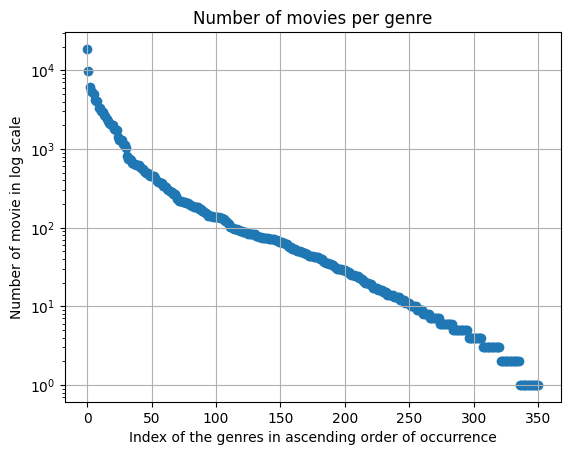

In [67]:
plt.scatter(nb_genres.index,nb_genres['nb of movies'])
plt.yscale("log")
plt.title('Number of movies per genre')
plt.xlabel('Index of the genres in ascending order of occurrence')
plt.ylabel('Number of movie in log scale')
plt.grid()


The 'nb_genres' frame shows that there are 351 different genres, and their occurrence decays as a power low. Indeed, as seen in the above plot, from the 100th genre, there are only 100 or less movies associated to it. This means that taking into account only the first genres will still describe most of the data.

**3.2) Creating main genres clusters**

In the 'nb_genres' frame, one can see that some genres could be grouped together in order to form a bigger group of data. For example, the genre 'Comedy' defines 9893 movies, and the genre 'Comedy film' defines 2423 movies, whereas they could be grouped together. 
Moreover, 8 main genres are chosen to describe the data: 
- Drama
- Comedy
- Romance
- Thriller
- Action
- Family film
- Horror
- Informative

These genres are chosen because they define a high proportion of data, and also because they are the ones that will be relevant further in our study, when the genre of a movie will be presented with respect to the month of release.

The code below creates the respective genre clusters, and gathers them in a 'main_genres' frame.

In [71]:
# Drama cluster 
drama_genres = nb_genres[nb_genres['genre name'].str.contains('Drama')]
drama_genres['main name'] = 'Drama'
drama_genres

,genre name,nb of movies,main name
0,Drama,18700,Drama
37,Family Drama,638,Drama
60,Crime Drama,341,Drama
92,Courtroom Drama,155,Drama
106,Musical Drama,129,Drama
109,Marriage Drama,115,Drama
120,Erotic Drama,90,Drama
130,Childhood Drama,82,Drama
179,Addiction Drama,42,Drama
217,Inspirational Drama,20,Drama


In [72]:
# Comedy cluster
comedy_genres = nb_genres[nb_genres['genre name'].str.contains('Comedy|Slapstick|Parody')]
comedy_genres['main name'] = 'Comedy'
comedy_genres

,genre name,nb of movies,main name
1,Comedy,9893,Comedy
15,Comedy film,2423,Comedy
29,Comedy-drama,1118,Comedy
42,Parody,577,Comedy
48,Slapstick,463,Comedy
80,Comedy of manners,192,Comedy
87,Crime Comedy,172,Comedy
90,Fantasy Comedy,161,Comedy
91,Domestic Comedy,160,Comedy
102,Comedy of Errors,135,Comedy


In [73]:
# Romance cluster
romance_genres = nb_genres[nb_genres['genre name'].str.contains('Romance|Romantic')]
romance_genres['main name'] = 'Romance'
romance_genres

,genre name,nb of movies,main name
2,Romance Film,6123,Romance
20,Romantic drama,1990,Romance
22,Romantic comedy,1760,Romance
161,Romantic fantasy,53,Romance
340,Romantic thriller,1,Romance


In [74]:
# Thriller cluster
thriller_genres = nb_genres[nb_genres['genre name'].str.contains('Thriller|Crime')]
thriller_genres['main name'] = 'Thriller'
thriller_genres

,genre name,nb of movies,main name
4,Thriller,5272,Thriller
6,Crime Fiction,4212,Thriller
25,Crime Thriller,1319,Thriller
60,Crime Drama,341,Thriller
62,Action Thrillers,307,Thriller
87,Crime Comedy,172,Thriller
156,Comedy Thriller,58,Thriller
176,Law & Crime,42,Thriller
188,Crime,34,Thriller
304,Sci-Fi Thriller,4,Thriller


In [75]:
# Action cluster
action_genres = nb_genres[nb_genres['genre name'].str.contains('Action|Adventure|War|Western')]
action_genres['main name'] = 'Action'
action_genres

,genre name,nb of movies,main name
5,Action,5026,Action
11,Adventure,3036,Action
14,Action/Adventure,2625,Action
24,War film,1402,Action
26,Western,1314,Action
62,Action Thrillers,307,Action
82,Family-Oriented Adventure,186,Action
93,Fantasy Adventure,149,Action
112,Adventure Comedy,101,Action
113,Action Comedy,99,Action


In [76]:
# Family film cluster
family_genres = nb_genres[nb_genres['genre name'].str.contains('Family|Animation|Child')]
family_genres['main name'] = 'Family Film'
family_genres

,genre name,nb of movies,main name
12,Family Film,2926,Family Film
19,Animation,2032,Family Film
37,Family Drama,638,Family Film
38,Children's/Family,634,Family Film
57,Children's,373,Family Film
81,Children's Fantasy,189,Family Film
82,Family-Oriented Adventure,186,Family Film
89,Computer Animation,162,Family Film
130,Childhood Drama,82,Family Film
269,Children's Entertainment,7,Family Film


In [77]:
# Drop movies which are not for Children
family_genres = family_genres.drop(family_genres.index[[2, 8, 10,11]])
family_genres

,genre name,nb of movies,main name
12,Family Film,2926,Family Film
19,Animation,2032,Family Film
38,Children's/Family,634,Family Film
57,Children's,373,Family Film
81,Children's Fantasy,189,Family Film
82,Family-Oriented Adventure,186,Family Film
89,Computer Animation,162,Family Film
269,Children's Entertainment,7,Family Film


In [78]:
# Horror cluster
horror_genres = nb_genres[nb_genres['genre name'].str.contains('Horror')]
horror_genres['main name'] = 'Horror'
horror_genres

,genre name,nb of movies,main name
13,Horror,2687,Horror
103,Horror Comedy,133,Horror
122,Sci-Fi Horror,87,Horror
185,Costume Horror,36,Horror
229,Road-Horror,16,Horror
332,Period Horror,2,Horror


In [79]:
# Informative cluster
informative_genres = nb_genres[nb_genres['genre name'].str.contains('Documentary|Biography|Biopic|History')]
informative_genres['main name'] = 'Informative'
informative_genres

,genre name,nb of movies,main name
17,Documentary,2140,Informative
32,Biography,749,Informative
49,History,457,Informative
54,Biopic [feature],390,Informative
201,Film & Television History,28,Informative
270,World History,7,Informative


In [80]:
#Creating the main genre dataframe so we can modify the original frame
main_genres =  pd.concat([drama_genres, comedy_genres,romance_genres,thriller_genres,action_genres,family_genres,horror_genres,informative_genres])
main_genres = main_genres.reset_index(drop = True)
main_genres

,genre name,nb of movies,main name
0,Drama,18700,Drama
1,Family Drama,638,Drama
2,Crime Drama,341,Drama
3,Courtroom Drama,155,Drama
4,Musical Drama,129,Drama
...,...,...,...
82,Biography,749,Informative
83,History,457,Informative
84,Biopic [feature],390,Informative
85,Film & Television History,28,Informative


**3.3) Assigning up to 2 main genres to each movie**

The goal now is to assign main genres to each movies, by using the 'main_genres' frame and iterating over all row of the original dataframe. 

In [82]:
# Deep copy
df_clean_genre = df_clean_date.copy(deep=True)
# Create empty column for 2 main genres
df_clean_genre['genre 1']= None
df_clean_genre['genre 2'] = None

# Iterate over rows of df_clean_genre
for index, row in df_clean_genre.iterrows():
        df_clean_genre2 = df_clean_genre.iloc[index]['Movie genres']
        df_clean_genre3 = json.loads(df_clean_genre2)
        df_clean_genre4 = pd.json_normalize(df_clean_genre3)

        for column in df_clean_genre4:
                boolarr = (main_genres['genre name'].isin([df_clean_genre4[column].iloc[0]]))
                if (boolarr.sum() ==1):
                        main_genre_value = main_genres[boolarr]['main name'].values
                        if (df_clean_genre['genre 1'].iloc[index] == None):
                                df_clean_genre['genre 1'].iloc[index] = main_genre_value
                        elif (df_clean_genre['genre 2'].iloc[index] == None and df_clean_genre['genre 1'].iloc[index]!= main_genre_value):
                                df_clean_genre['genre 2'].iloc[index] = main_genre_value
                #case where a sub genre belongs to more than one main genre: ex: 'Crime Comedy' (iloc[796])
                if (boolarr.sum() ==2):
                        if (df_clean_genre['genre 1'].iloc[index] == None and df_clean_genre['genre 2'].iloc[796] == None):
                                df_clean_genre['genre 1'].iloc[index] = main_genres[boolarr]['main name'].iloc[0]
                                df_clean_genre['genre 2'].iloc[index] = main_genres[boolarr]['main name'].iloc[1]
df_clean_genre.head()

,Wikipedia movieID,Freebase movieID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year,Movie release month,genre 1,genre 2
0,13388989,/m/03c3qdq,Pirate Gold,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,1,None,None
1,15839614,/m/03nwzrh,Hinemoa,NaN,24.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,3,Drama,None
2,14071789,/m/03cspdc,The Twelfth Juror,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,4,Drama,None
3,7709364,/m/0kvflk,In the Mountains of Virginia,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,10,None,None
4,13389288,/m/03c3qzt,Brothers,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,2,Drama,None


In [84]:
# Drop the movie genres column 
df_clean_genre = df_clean_genre.drop(columns='Movie genres')

In [90]:
df_clean_genre.head(5)

,Wikipedia movieID,Freebase movieID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie release year,Movie release month,genre 1,genre 2
0,13388989,/m/03c3qdq,Pirate Gold,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,1,None,None
1,15839614,/m/03nwzrh,Hinemoa,NaN,24.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",1913,3,Drama,None
2,14071789,/m/03cspdc,The Twelfth Juror,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,4,Drama,None
3,7709364,/m/0kvflk,In the Mountains of Virginia,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,10,None,None
4,13389288,/m/03c3qzt,Brothers,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,2,Drama,None


The final dataframe 'df_clean_genre' has release date and main genres easily accessible, so that further studies can be done. Since the computational cost is high for filtering the genre column, a new .tsv file is created so that each team member can access the processed dataframe without having to filter again.

In [88]:
# Delete already existing tsv TO BE MODIFIED
import os
os.remove('Data/movie.metadata.genres.tsv')

In [89]:
# create tsv file to store the new df_main_years
df_clean_genre.to_csv('Data/movie.metadata.genres.tsv', sep='\t')

#### **3) Processing the box office revenue column?**

# Part 2: Describing data
#### **1) Plots**
#### **2) Statistics**
#### **2) ...**
